## Import libraries, load ASR function, unzip dataset, and download model

In [ ]:
# Install requirements for the text generation model
!pip install -r requirements.txt

In [1]:
# Import packages
import os
import transformers
import torchaudio
import numpy as np
import sentencepiece
import regex as re
import csv
import string
from pydub import AudioSegment
import pandas as pd

from pyctcdecode import build_ctcdecoder
from transformers import Wav2Vec2ProcessorWithLM, Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, AutoTokenizer, AutoModelForSeq2SeqLM
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

This function performs text generation from audio files in wav format.
It loads the audio file into an array, adjust the sample rate to the one required by the model (16000) and run it into the model that generates text from the waveform.

In [12]:
def asr_model(wav_file, model, processor):
    waveform, sample_rate = torchaudio.load(wav_file)
    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000, resampling_method='sinc_interpolation')
    # Downsampling is required to match the model's frequency, i.e.
    # the frequency of the dataset the model was trained on.
    speech_array = resampler(waveform).squeeze().numpy()
    inputs = processor(speech_array, sampling_rate=16000, return_tensors="pt")['input_values']
    # Detach the tensors first (otherwise, they require gradients
    # to be computed); also, since we're simulating the inference
    # squeeze the resulting array at the first dimension (batch_size),
    # otherwise, leave it as is, and call batch_decode() instead.
    outputs = model(inputs)['logits'].detach().numpy().squeeze(0)
    return(processor.decode(outputs).text)

Download model and processor to be used in the function above.

In [8]:
model = Wav2Vec2ForCTC.from_pretrained("Yehor/wav2vec2-xls-r-300m-uk-with-small-lm")

In [9]:
processor = Wav2Vec2ProcessorWithLM.from_pretrained("Yehor/wav2vec2-xls-r-300m-uk-with-small-lm")

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'snapshot_download': allow_regex. Will not be supported from version '0.12'.

Please use `allow_patterns` and `ignore_patterns` instead.
  warnings.warn(message, FutureWarning)


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading the LM will be faster if you build a binary file.
Reading /home/studio-lab-user/.cache/pyctcdecode/models--Yehor--wav2vec2-xls-r-300m-uk-with-small-lm/snapshots/bbd936400e7566ba44560440aa4abd05b5983c17/language_model/5gram_correct.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


In [ ]:
# Extract from the compressed dataset
!tar -xvzf cv-corpus-11.0-2022-09-21-uk.tar.gz -C /home/studio-lab-user/sagemaker-studiolab-notebooks

## Prepare dataset

After extracting the files, change directory to the files location. List all the files or directories in the location to open or access the files from them. 

In [4]:
# Save list of directories in the dataset folder

%cd '/home/studio-lab-user/sagemaker-studiolab-notebooks/content/drive/MyDrive/cv/cv_wav'

files = os.listdir()
print(len(files))

/home/studio-lab-user/sagemaker-studiolab-notebooks/content/drive/MyDrive/cv/cv_wav
15415


Create a variable to store the file paths and their corresponding transcripts. The variable is a list containing sublists for each pair if path and transcript.
Then, open each file in the list created before. For each line of the opened file, use regular expressions to extract the path and the transcript from the line. Store them in temporary variables. Because the output from the findall function is a list, concatenate the two variables before appending them to the main list "text". Also, as the files contain a header line that won't match the regular expression search, append only the lines that don't return an empty list.

In [ ]:
text = []

for file in files:
    with open(file, 'r', encoding='utf8') as f:

        for line in f:
            path = re.findall('\t(.+mp3)', line)
            transcript = re.findall('\t.+mp3\t(.+?)\t', line)
            l = path+transcript
            if l != []:
                text.append(l)
print(text[:5])

## Generate text

Change the working directory again to create a csv file that will store all the paths, transcripts, and generated text from the ASR model. The file creation is done in a separate cell because it writes a header to the file, this way the header is not written again when re-running the cell to append more sentences.

In [20]:
%cd '/home/studio-lab-user/sagemaker-studiolab-notebooks/'

/home/studio-lab-user/sagemaker-studiolab-notebooks


In [9]:
# Create csv file with header

with open('cv11_transcription_generated-text.csv', 'w', encoding='UTF8', newline='\n') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(['path', 'transcription', 'generated_text'])

The loop below first converts the mp3 file into wav format, changes the file name to match the .wav extension, and calls the function to generate text. The output is saved into a variable that is appended to the list containing the path and transcript for the sentence.
Lastly, the sublist corresponding to the sentence, containing path + transcript + generated text, is written as a new line into the file created earlier.

PS.: the option to write one line at a time to the file was made because with large datasets, the notebook can crash for a number or reasons. When this happens, this cell can be re-run from where it stopped by replacing the 0 that sets the initial range in the for loop with the number of the last line written to the file (and not the last line, since the range starts at 0 and the lines in the file are counted from 1). Otherwise, the content appended to the text variable would have been lost.

In [ ]:
%cd '/home/studio-lab-user/sagemaker-studiolab-notebooks/CV11/uk/clips'

# Append generated text in the list and save to csv file
for i in range(0, len(text)):
    #convert mp3 to wav
    sound = AudioSegment.from_mp3(text[i][0])
    sound = sound.export(text[i][0].rstrip('.mp3')+'.wav', format='wav')
    gen_text = asr_model(sound, model, processor)
    text[i].append(gen_text)

    with open('/home/studio-lab-user/sagemaker-studiolab-notebooks/cv11_transcription_generated-text.csv', 'a', encoding='UTF8', newline='\n') as f:
        writer = csv.writer(f)

        # write the data
        writer.writerows(text[i:i+1])

/home/studio-lab-user/sagemaker-studiolab-notebooks/CV11/uk/clips


## Length Classification

Load the csv containing the wav path, transcript, and generated text as a pandas dataframe.

In [4]:
transcripts = pd.read_csv("cv11_transcription_generated-text.csv", encoding='utf-8')

In [14]:
transcripts

,path,transcription,generated_text
0,common_voice_uk_23561219.mp3,А цим «пустунам» пане Лужков теж не вистачає С...,а цим пустунам пане лужков теж не вистачає сев...
1,common_voice_uk_23561220.mp3,Що нам із чужого ясного чи злого,що нам із чужого ясного чи злого
2,common_voice_uk_23561225.mp3,Так хан Великого Степу став легітимним Царем у...,так хан великого степу став легітимним царем у...
3,common_voice_uk_23561349.mp3,Не сій на межі жита ані мудрості на серці неро...,не сій на межі жита ані мудрості на серці неро...
4,common_voice_uk_23561363.mp3,Ні Ось іще одна книга солідніша академічне вид...,ні ось іще одна книга солідніша академічне вид...
...,...,...,...
54834,common_voice_uk_25959003.wav,І ще одне,і ще одне
54835,common_voice_uk_25969663.wav,Не перелічуватиму безліч лих які принесли на с...,не перелічуватиму безліч лих які принесли на с...
54836,common_voice_uk_26034763.wav,Про арешт або затримання людини має бути негай...,про арештабо затримання людини має бути негайн...
54837,common_voice_uk_26035083.wav,Хто не жив посеред бурі той ціни не знає силі,хто не жив посеред бурі той ціни не знає силі


To calculate the length difference between the transcript and the generated text, first remove punctuation characters from the transcripts, as they won't be included in the generated text, and the newline character, if it is present in the transcript.
Then, try to subtract the length of the generated text from the transcript length. Append the result to a list. The except block catches cases in which some problem occured in the text generation and assigns the value of -10 to the length, so the transcript can be manually checked later as it will be considered an incomplete transcript. 

In [15]:
# Calculate length difference between transcripts
length = []
for i in range(len(transcripts['path'])):
    transcripts['transcription'][i] = transcripts['transcription'][i].translate(str.maketrans('', '', string.punctuation))
    if transcripts['transcription'][i].endswith('\n'):
        transcripts['transcription'][i] = transcripts['transcription'][i].rstrip('\n')
    try:
        length.append(len(transcripts['transcription'][i]) - len(transcripts['generated_text'][i]))
    except:
        length.append(-10)

In [30]:
transcripts

,Unnamed: 0,path,transcription,generated_text,length_diff,length_cat
0,0,common_voice_uk_23561219.mp3,А цим «пустунам» пане Лужков теж не вистачає С...,а цим пустунам пане лужков теж не вистачає сев...,2,complete
1,1,common_voice_uk_23561220.mp3,Що нам із чужого ясного чи злого,що нам із чужого ясного чи злого,0,complete
2,2,common_voice_uk_23561225.mp3,Так хан Великого Степу став легітимним Царем у...,так хан великого степу став легітимним царем у...,-1,complete
3,3,common_voice_uk_23561349.mp3,Не сій на межі жита ані мудрості на серці неро...,не сій на межі жита ані мудрості на серці неро...,0,complete
4,4,common_voice_uk_23561363.mp3,Ні Ось іще одна книга солідніша академічне вид...,ні ось іще одна книга солідніша академічне вид...,2,complete
...,...,...,...,...,...,...
54834,54834,common_voice_uk_25959003.mp3,І ще одне,і ще одне,0,complete
54835,54835,common_voice_uk_25969663.mp3,Не перелічуватиму безліч лих які принесли на с...,не перелічуватиму безліч лих які принесли на с...,0,complete
54836,54836,common_voice_uk_26034763.mp3,Про арешт або затримання людини має бути негай...,про арештабо затримання людини має бути негайн...,1,complete
54837,54837,common_voice_uk_26035083.mp3,Хто не жив посеред бурі той ціни не знає силі,хто не жив посеред бурі той ціни не знає силі,0,complete


Create a colum in the dataframe using the list with the length difference between transcripts.

In [16]:
# Create column in dataframe
transcripts['length_diff'] = length
transcripts

,path,transcription,generated_text,length_diff
0,common_voice_uk_23561219.mp3,А цим «пустунам» пане Лужков теж не вистачає С...,а цим пустунам пане лужков теж не вистачає сев...,2
1,common_voice_uk_23561220.mp3,Що нам із чужого ясного чи злого,що нам із чужого ясного чи злого,0
2,common_voice_uk_23561225.mp3,Так хан Великого Степу став легітимним Царем у...,так хан великого степу став легітимним царем у...,-1
3,common_voice_uk_23561349.mp3,Не сій на межі жита ані мудрості на серці неро...,не сій на межі жита ані мудрості на серці неро...,0
4,common_voice_uk_23561363.mp3,Ні Ось іще одна книга солідніша академічне вид...,ні ось іще одна книга солідніша академічне вид...,2
...,...,...,...,...
54834,common_voice_uk_25959003.wav,І ще одне,і ще одне,0
54835,common_voice_uk_25969663.wav,Не перелічуватиму безліч лих які принесли на с...,не перелічуватиму безліч лих які принесли на с...,0
54836,common_voice_uk_26034763.wav,Про арешт або затримання людини має бути негай...,про арештабо затримання людини має бути негайн...,1
54837,common_voice_uk_26035083.wav,Хто не жив посеред бурі той ціни не знає силі,хто не жив посеред бурі той ціни не знає силі,0


In [17]:
print(len(transcripts['length_diff']))

54839


Based on the difference, classificate each transcript into one of three categories: incomplete (difference is equal or less than -10), inconclusive (difference is equal to or less than -5), or complete (difference is greater than -5). Save the classification as a new column of the dataframe and then save the dataframe as a csv file.

In [18]:
# Classificate transcripts according to length difference

transcripts['length_cat'] = [0 for x in range(len(transcripts['length_diff']))]

for i in range(len(transcripts['length_diff'])):
    if transcripts['length_diff'][i] <= -10:
        transcripts['length_cat'][i] = 'incomplete'
    elif transcripts['length_diff'][i] <= -5:
        transcripts['length_cat'][i] = 'inconclusive'
    else:
        transcripts['length_cat'][i] = 'complete'
    

transcripts.to_csv('transcripts_length_cat_cv11.csv', encoding='utf-8')
transcripts.head()

/tmp/ipykernel_75/715380660.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts['length_cat'][i] = 'complete'


,path,transcription,generated_text,length_diff,length_cat
0,common_voice_uk_23561219.mp3,А цим «пустунам» пане Лужков теж не вистачає С...,а цим пустунам пане лужков теж не вистачає сев...,2,complete
1,common_voice_uk_23561220.mp3,Що нам із чужого ясного чи злого,що нам із чужого ясного чи злого,0,complete
2,common_voice_uk_23561225.mp3,Так хан Великого Степу став легітимним Царем у...,так хан великого степу став легітимним царем у...,-1,complete
3,common_voice_uk_23561349.mp3,Не сій на межі жита ані мудрості на серці неро...,не сій на межі жита ані мудрості на серці неро...,0,complete
4,common_voice_uk_23561363.mp3,Ні Ось іще одна книга солідніша академічне вид...,ні ось іще одна книга солідніша академічне вид...,2,complete


To have a picture about the completeness of the transcripts, count and plot the values in each category.

In [31]:
# Count n of transcripts per category
transcripts['length_cat'].value_counts()

complete        54802
inconclusive       31
incomplete          6
Name: length_cat, dtype: int64

<AxesSubplot: >

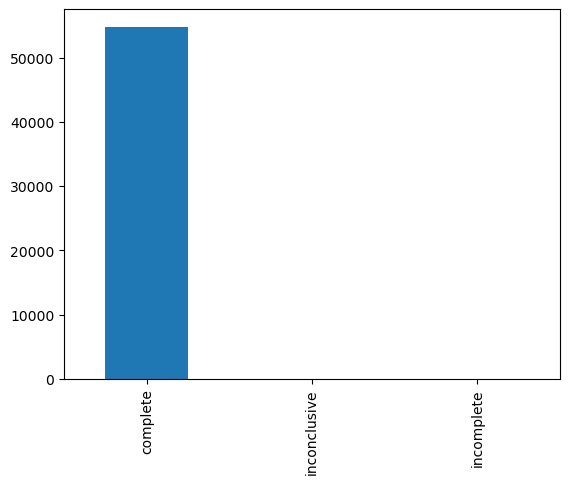

In [32]:
transcripts['length_cat'].value_counts().plot.bar()

Finally, select only the transcripts classificated as incomplete or inconclusive and save them into a text file for manual inspection. The text file contains the path, the transcript, and the generated text, each in a different line, with a blank line separating each sentence.

In [33]:
# Select only transcripts in the incomplete and inconclusive categories
txt = transcripts.loc[(transcripts['length_cat'] == 'incomplete') | (transcripts['length_cat'] == 'inconclusive')]
txt

,Unnamed: 0,path,transcription,generated_text,length_diff,length_cat
192,192,common_voice_uk_23563667.mp3,Навіть у царській Росії наприкінці ХIХ столітт...,навіть у царській росії на про кінці девятнадц...,-13,incomplete
2274,2274,common_voice_uk_20930462.mp3,Я родом зі Львова,я родом зі львовенепра,-5,inconclusive
3303,3303,common_voice_uk_26816172.mp3,Ті кого викликали розгублено збирали манаття п...,ті кого викликали розгублено збирали мене мана...,-5,inconclusive
4211,4211,common_voice_uk_27328146.mp3,Приглядаємося до вязнів,приглядаємося до в'язнів живі ріж ідемо,-16,incomplete
5456,5456,common_voice_uk_32461346.mp3,Бо чоловік оцієї жінки пяниця часто пізно вноч...,бо чоловік у цієї жінки п'яниться часто пізно ...,-6,inconclusive
7444,7444,common_voice_uk_23570493.mp3,Ось про що писав сучасник Петра І,ось про що писав сучасник петра першого,-6,inconclusive
8405,8405,common_voice_uk_21757542.mp3,З чим баба на торг з тим з торгу,з чим баба на торг з тим сторогучо що,-5,inconclusive
8407,8407,common_voice_uk_21757544.mp3,Манна небесна несподівано одержані життєві блага,манна небесне несподівано одержання житевжиттє...,-5,inconclusive
8737,8737,common_voice_uk_23550690.mp3,Злодійське дійство пане Солженіцин вчинив цар ...,злодійське дійство пане солженіцин вчинив цар ...,-5,inconclusive
9386,9386,common_voice_uk_23554411.mp3,Велике дзеркало завжди затьмарює менше,велике дзеркало завжди затьмарює менше вироби,-7,inconclusive


In [35]:
print(len(txt))

37


In [37]:
# Save in a text file
with open('transcripts_cv11.txt', 'w', encoding='utf-8') as f:
    for t in range(len(txt)):
        try:
            f.write(txt.iloc[t,1]+"\n")
            f.write(txt.iloc[t,2]+"\n")
            f.write(txt.iloc[t,3]+"\n")
            f.write('\n\n')
        except:
            print(txt.iloc[t,0])
            print(txt.iloc[t,1])
            print(txt.iloc[t,2])

11679
common_voice_uk_23561777.mp3
Ні
